In [7]:
"""
This module demonstrates a Fourier Neural Network applied to synthetic financial time series data.

A Fourier Neural Network uses sinusoidal activation functions to model periodic patterns in data,
which can be particularly useful for capturing cyclical behaviors in financial time series.

In this example, we generate synthetic stock price data with underlying periodic components,
train the network to predict future stock prices, and visualize the results.
"""

import numpy as np
import matplotlib.pyplot as plt

In [8]:
def generate_synthetic_stock_data(num_points: int, noise_level: float = 0.1) -> tuple:
    """
    Generates synthetic stock price data with periodic components, trends, and noise.

    Args:
        num_points (int): Number of data points to generate.
        noise_level (float): Standard deviation of the Gaussian noise.

    Returns:
        tuple: Tuple containing time steps and corresponding stock prices.
    """
    np.random.seed(0)  # For reproducibility
    t: np.ndarray = np.arange(num_points)
    trend: np.ndarray = t * 0.05  # Linear trend
    seasonal: np.ndarray = 2 * np.sin(0.02 * t) + 0.5 * np.sin(0.1 * t)  # Seasonal components
    noise: np.ndarray = np.random.normal(0, noise_level, num_points)  # Random noise
    stock_prices: np.ndarray = 50 + trend + seasonal + noise  # Synthetic stock prices
    return t, stock_prices

In [9]:
class FourierNeuralNetwork:
    """
    A Fourier Neural Network that uses sinusoidal activation functions to model periodic data.

    Attributes:
        W1 (np.ndarray): Weights of the first (input to hidden) layer.
        b1 (np.ndarray): Biases of the first layer.
        W2 (np.ndarray): Weights of the second (hidden to output) layer.
        b2 (np.ndarray): Biases of the second layer.
    """

    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """
        Initializes the Fourier Neural Network with random weights and biases.

        Args:
            input_size (int): Number of input neurons.
            hidden_size (int): Number of neurons in the hidden layer.
            output_size (int): Number of output neurons.
        """
        # Scale down the weights to prevent large activations
        self.W1: np.ndarray = np.random.randn(input_size, hidden_size) * 0.1
        self.b1: np.ndarray = np.zeros((1, hidden_size))
        self.W2: np.ndarray = np.random.randn(hidden_size, output_size) * 0.1
        self.b2: np.ndarray = np.zeros((1, output_size))

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Performs a forward pass through the network.

        Args:
            X (np.ndarray): Input data of shape (n_samples, input_size).

        Returns:
            np.ndarray: Output of the network of shape (n_samples, output_size).
        """
        self.Z1: np.ndarray = np.dot(X, self.W1) + self.b1  # Linear combination
        self.A1: np.ndarray = np.sin(self.Z1)               # Sinusoidal activation
        Z2: np.ndarray = np.dot(self.A1, self.W2) + self.b2 # Output layer
        return Z2

    def compute_loss(self, Y_pred: np.ndarray, Y_true: np.ndarray) -> float:
        """
        Computes the Mean Squared Error loss.

        Args:
            Y_pred (np.ndarray): Predicted outputs.
            Y_true (np.ndarray): True outputs.

        Returns:
            float: The Mean Squared Error loss.
        """
        loss: float = np.mean((Y_pred - Y_true) ** 2)
        return loss

    def train(self, X: np.ndarray, Y: np.ndarray, learning_rate: float, epochs: int):
        """
        Trains the network using gradient descent optimization.

        Args:
            X (np.ndarray): Input data of shape (n_samples, input_size).
            Y (np.ndarray): Target data of shape (n_samples, output_size).
            learning_rate (float): Learning rate for weight updates.
            epochs (int): Number of times to iterate over the training data.
        """
        n_samples: int = X.shape[0]
        for epoch in range(epochs):
            # Forward pass
            Y_pred: np.ndarray = self.forward(X)

            # Compute loss
            loss: float = self.compute_loss(Y_pred, Y)

            # Backward pass
            dY_pred: np.ndarray = (2 / n_samples) * (Y_pred - Y)        # Loss derivative w.r.t Y_pred
            dW2: np.ndarray = np.dot(self.A1.T, dY_pred)                # Gradient for W2
            db2: np.ndarray = np.sum(dY_pred, axis=0, keepdims=True)    # Gradient for b2

            dA1: np.ndarray = np.dot(dY_pred, self.W2.T)                # Gradient w.r.t activation
            dZ1: np.ndarray = dA1 * np.cos(self.Z1)                     # Gradient w.r.t pre-activation
            dW1: np.ndarray = np.dot(X.T, dZ1)                          # Gradient for W1
            db1: np.ndarray = np.sum(dZ1, axis=0, keepdims=True)        # Gradient for b1

            # Update weights and biases
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2

            # Print the loss every 10% of the total epochs
            if (epoch + 1) % max(1, epochs // 10) == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")

Epoch 1/5000, Loss: 0.863273
Epoch 500/5000, Loss: 0.001119
Epoch 1000/5000, Loss: 0.001011
Epoch 1500/5000, Loss: 0.000949
Epoch 2000/5000, Loss: 0.000905
Epoch 2500/5000, Loss: 0.000870
Epoch 3000/5000, Loss: 0.000841
Epoch 3500/5000, Loss: 0.000815
Epoch 4000/5000, Loss: 0.000791
Epoch 4500/5000, Loss: 0.000769
Epoch 5000/5000, Loss: 0.000749


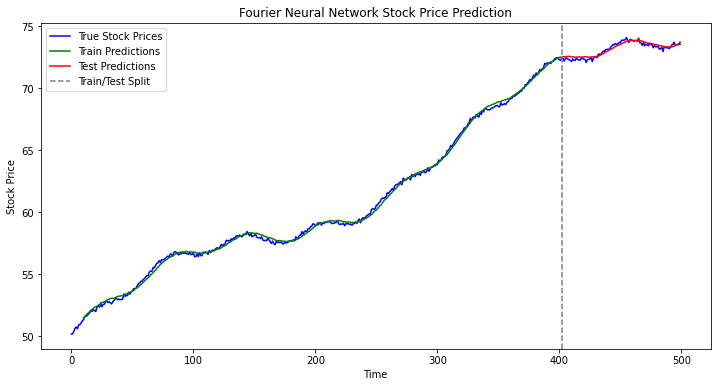

In [10]:
if __name__ == "__main__":
    """
    Example usage of the Fourier Neural Network to predict synthetic stock price movements.
    """
    # Generate synthetic stock price data
    num_points: int = 500
    t, stock_prices = generate_synthetic_stock_data(num_points)

    # Normalize the data
    stock_prices_mean = np.mean(stock_prices)
    stock_prices_std = np.std(stock_prices)
    stock_prices_norm = (stock_prices - stock_prices_mean) / stock_prices_std

    # Prepare the dataset
    look_back: int = 10  # Number of previous time steps to use as input variables
    X = []
    Y = []
    for i in range(len(stock_prices_norm) - look_back):
        X.append(stock_prices_norm[i:i + look_back])
        Y.append(stock_prices_norm[i + look_back])

    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)

    # Split into training and testing datasets
    split_ratio: float = 0.8
    split_index: int = int(len(X) * split_ratio)
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]

    # Initialize the Fourier Neural Network
    input_size: int = look_back
    hidden_size: int = 50
    output_size: int = 1
    fnn: FourierNeuralNetwork = FourierNeuralNetwork(input_size, hidden_size, output_size)

    # Train the network
    learning_rate: float = 0.01
    epochs: int = 5000
    fnn.train(X_train, Y_train, learning_rate, epochs)

    # Predict using the trained network
    Y_pred_train: np.ndarray = fnn.forward(X_train)
    Y_pred_test: np.ndarray = fnn.forward(X_test)

    # Denormalize the predictions
    Y_pred_train_denorm = Y_pred_train * stock_prices_std + stock_prices_mean
    Y_pred_test_denorm = Y_pred_test * stock_prices_std + stock_prices_mean

    # Denormalize the actual prices
    Y_train_denorm = Y_train * stock_prices_std + stock_prices_mean
    Y_test_denorm = Y_test * stock_prices_std + stock_prices_mean

    # Prepare data for plotting
    train_time = t[look_back:look_back + len(Y_pred_train)]
    test_time = t[look_back + len(Y_pred_train):look_back + len(Y_pred_train) + len(Y_pred_test)]

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(t, stock_prices, label='True Stock Prices', color='blue')
    plt.plot(train_time, Y_pred_train_denorm.flatten(), label='Train Predictions', color='green')
    plt.plot(test_time, Y_pred_test_denorm.flatten(), label='Test Predictions', color='red')
    plt.axvline(x=split_index + look_back, color='gray', linestyle='--', label='Train/Test Split')
    plt.title('Fourier Neural Network Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


# Fourier Neural Network for Stock Price Prediction

### Summary:
This Jupyter notebook implements a Fourier Neural Network (FNN) for predicting stock prices using time series data. The key functionality includes:
1. **Data Preprocessing**: The stock price data is normalized, and a time-series look-back window is applied to generate training and testing datasets.

2. **Fourier Neural Network Architecture**:
   - The FNN class is defined, consisting of an input layer, a hidden layer with Fourier transformations, and an output layer.
   - The network is trained using backpropagation to minimize the error between predicted and actual stock prices.
   
3. **Model Training and Prediction**:
   - The notebook trains the FNN on the training set and then makes predictions for both the training and test sets.
   
4. **Results Visualization**:
   - After training, the predicted stock prices are denormalized and plotted alongside the actual stock prices.
   - A graph is displayed showing the stock price predictions for both the training and testing datasets, with a clear train/test split indicated.

### Key Steps:
1. **Data Preparation**:
   - Load the stock price data.
   - Normalize the data to ensure better training performance.
   - Apply a look-back window to create sequences of data for training the network.<br><br>

2. **Fourier Neural Network (FNN) Class**:
   - **Forward Propagation**: Passes the data through the network using Fourier transformations.
   - **Backpropagation**: Trains the network by adjusting weights to minimize the mean squared error (MSE).
   <br><br>
3. **Model Training**:
   - The model is trained over a specified number of epochs with a defined learning rate.
   - After training, the network is used to predict stock prices on both the training and test datasets.
<br><br>
4. **Evaluation**:
   - Predictions are denormalized back to the original stock price scale.
   - The results are visualized by plotting true stock prices against the predicted values for both the training and test sets.

### Visualization:
- A plot is generated showing:
   - The true stock prices in blue.
   - The training predictions in green.
   - The test predictions in red.
   - A vertical gray line indicating the point at which the data is split into training and test sets.

### Conclusion:
This notebook provides an example of how Fourier Neural Networks can be applied to time-series data, particularly for financial stock prediction tasks. It demonstrates the ability of FNNs to model complex patterns in stock prices and make future predictions.
